<a href="https://colab.research.google.com/github/romulokps/testesPCR/blob/main/resultadoTesteNA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)
/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:328: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) a

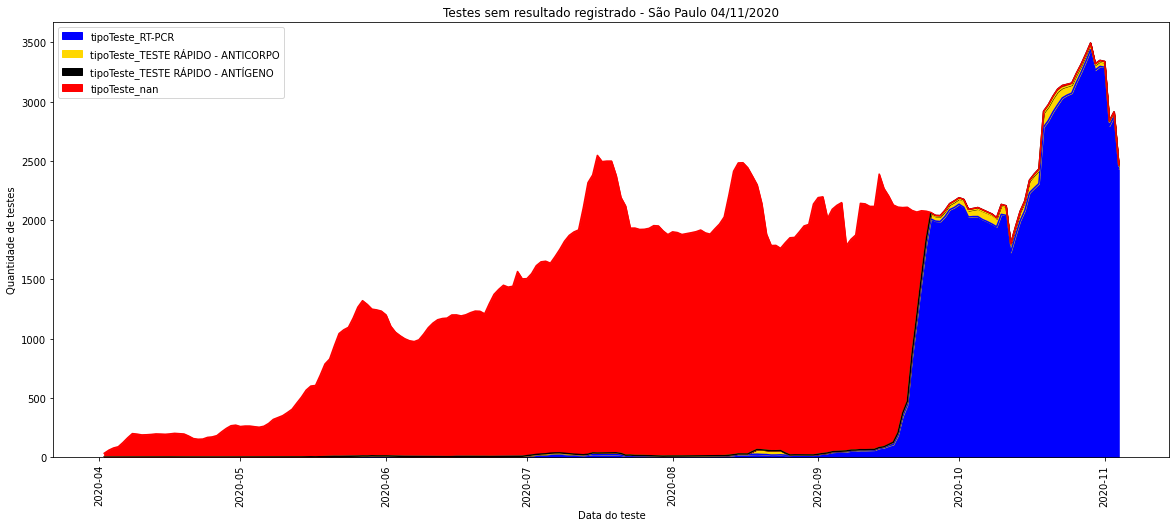

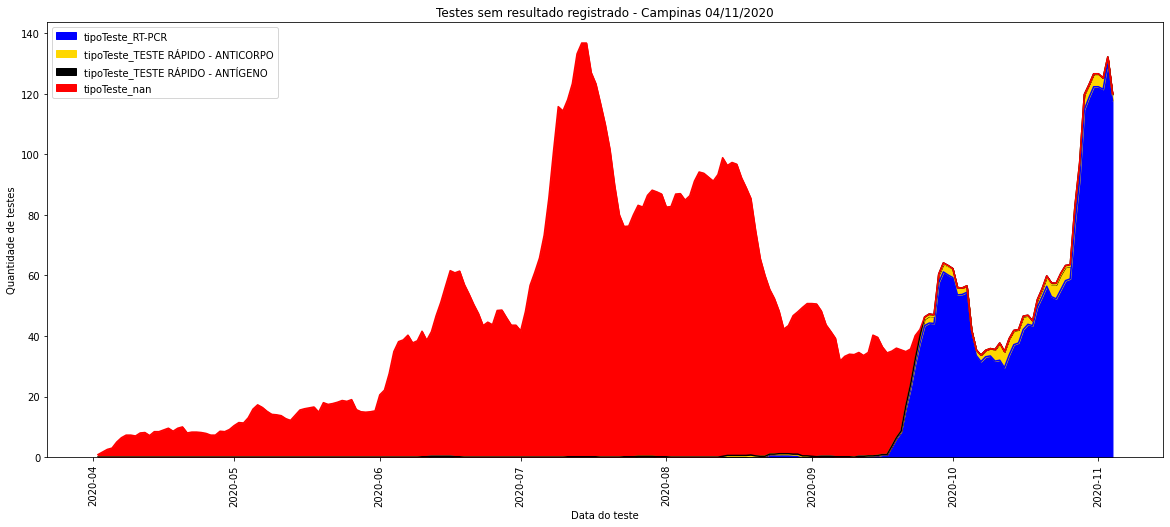

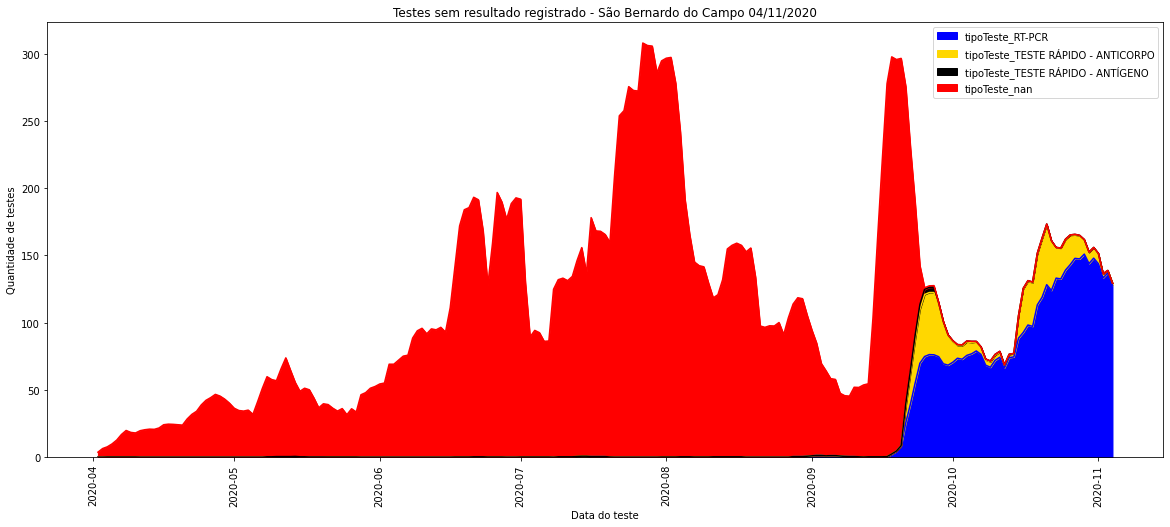

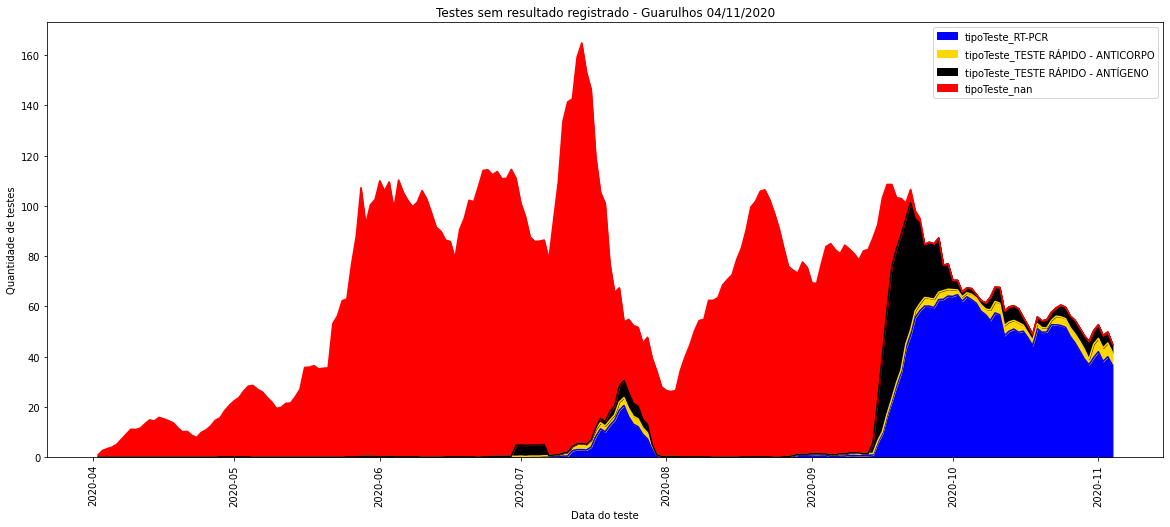

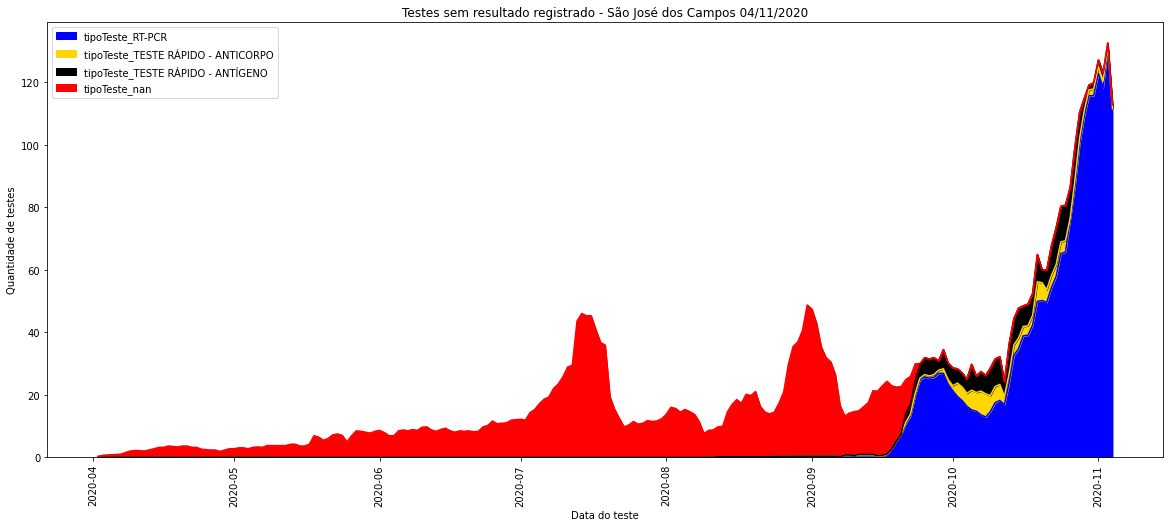

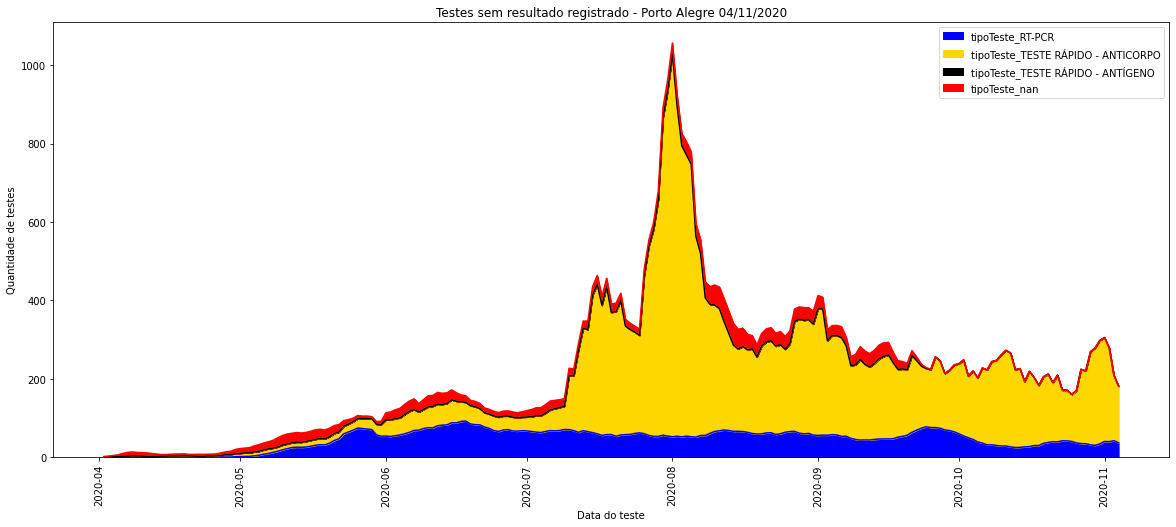

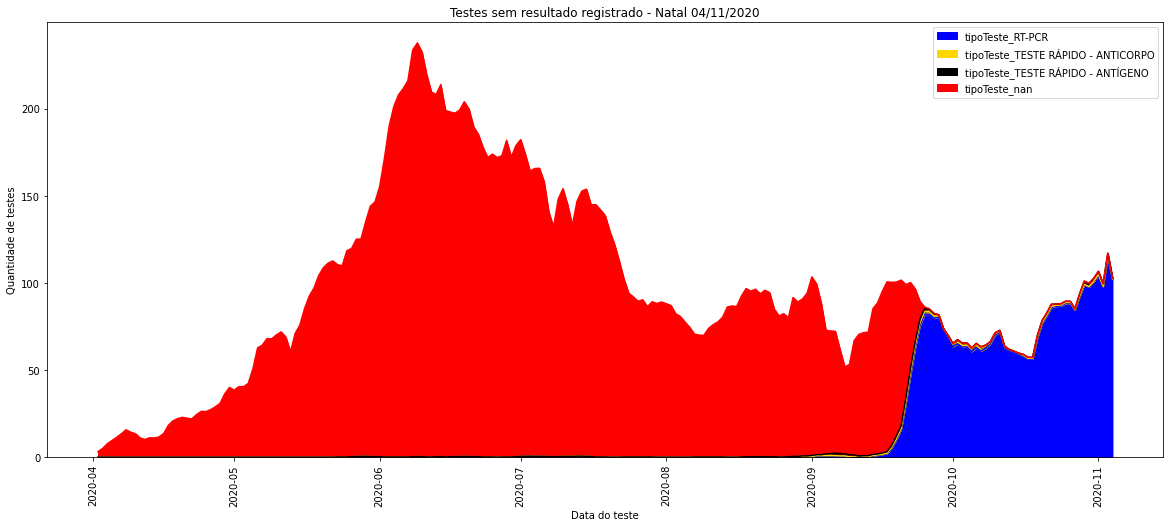

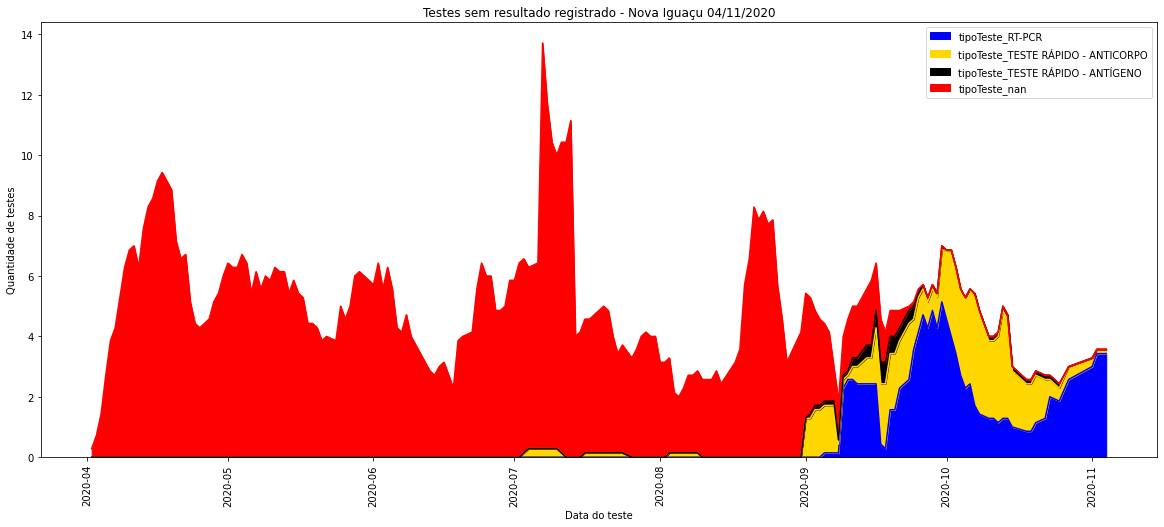

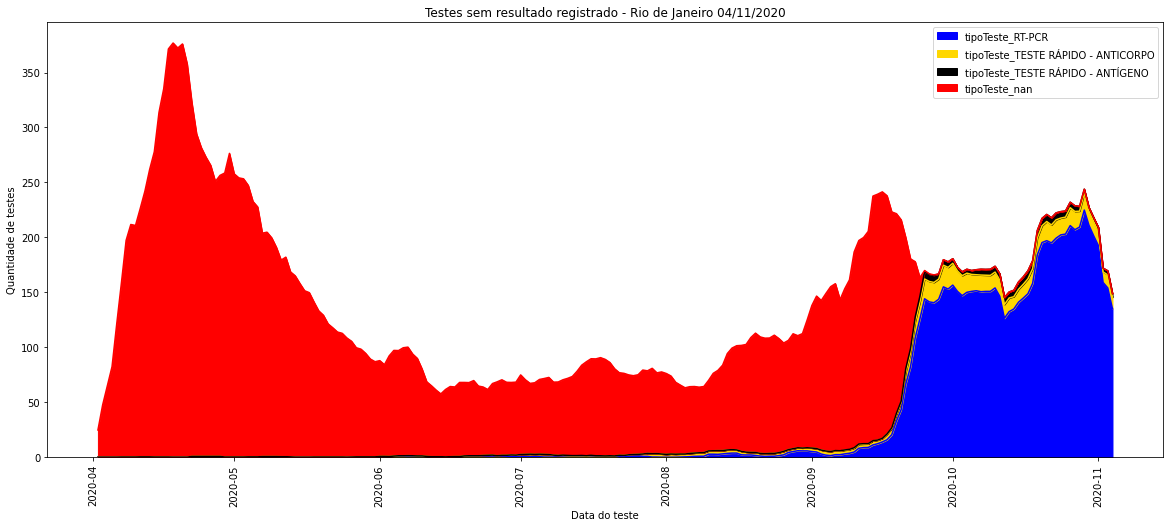

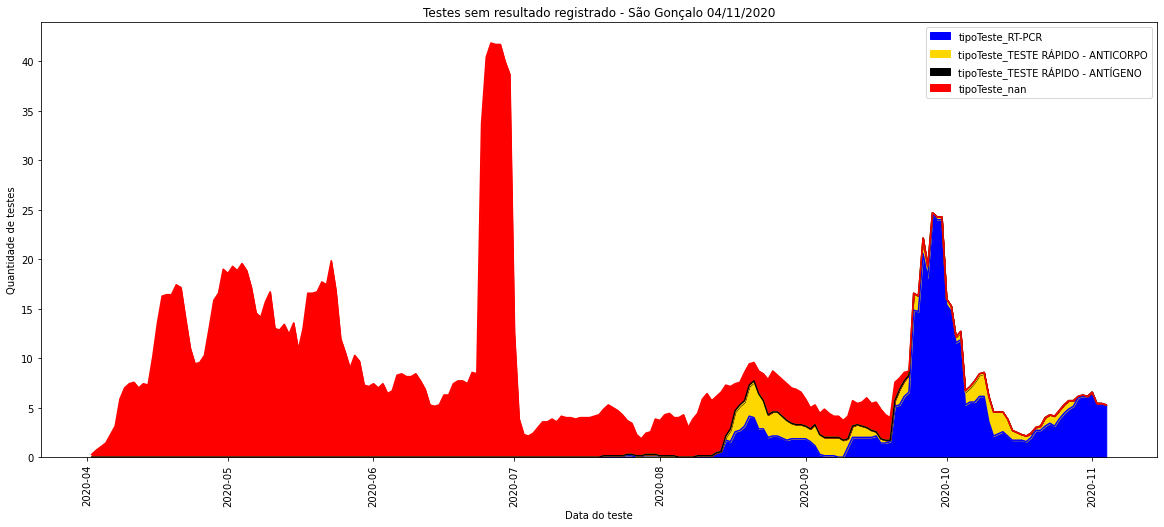

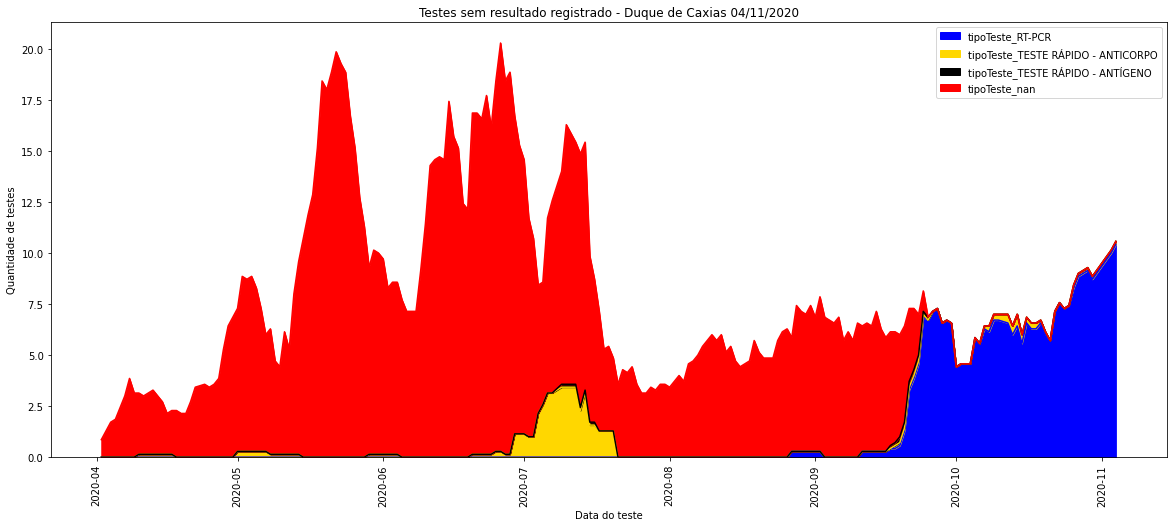

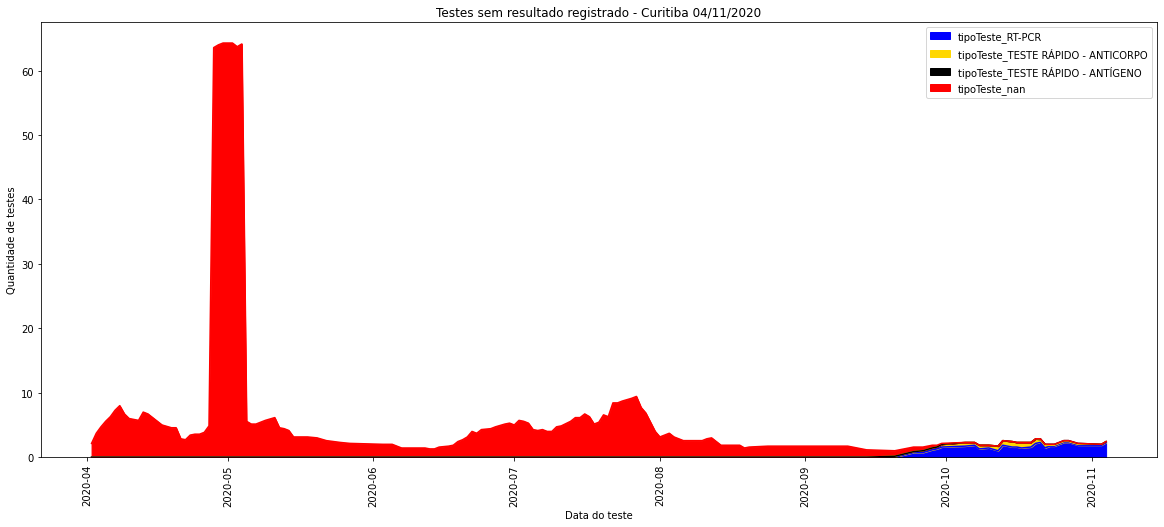

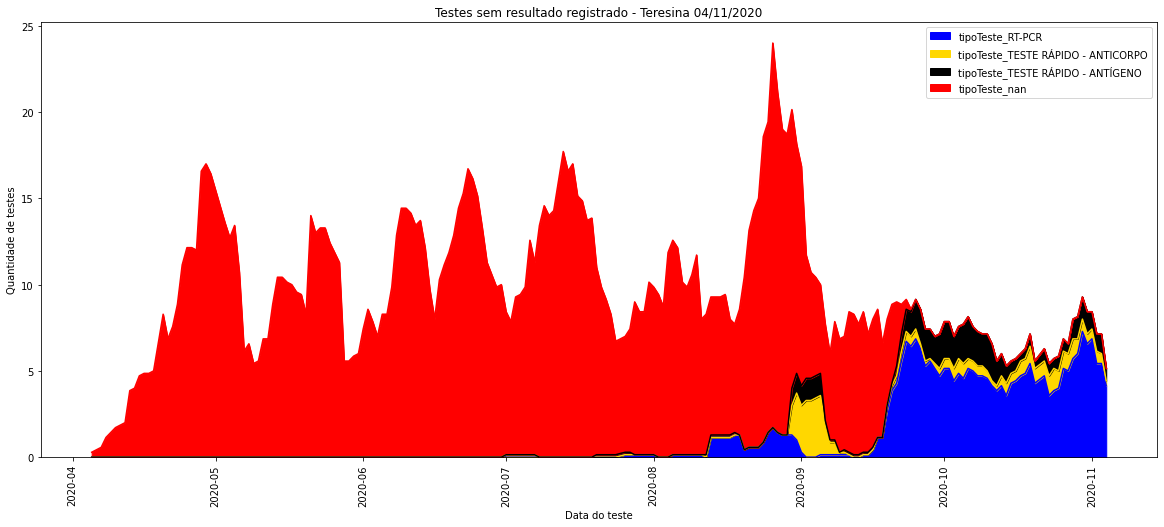

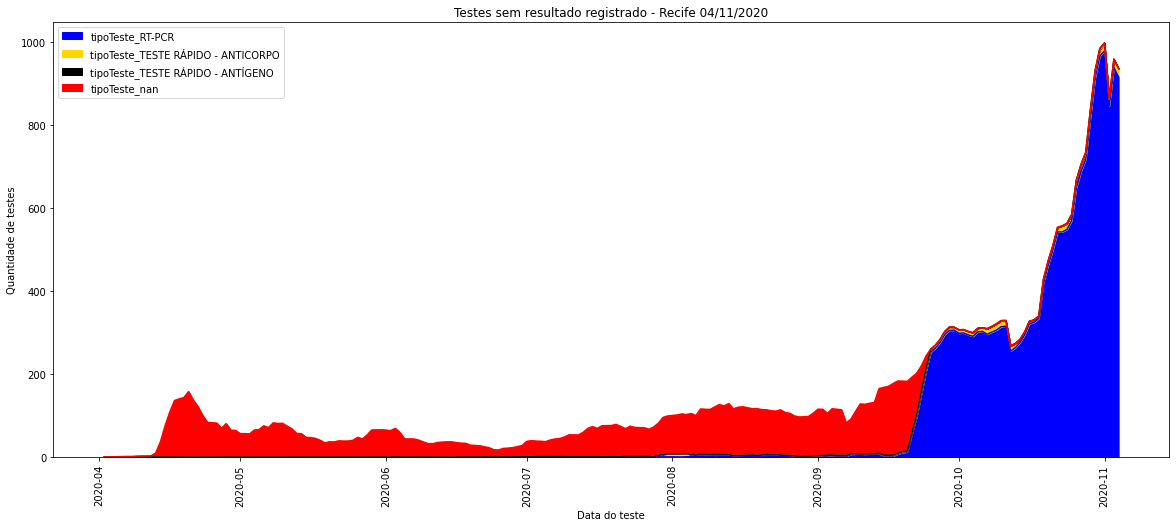

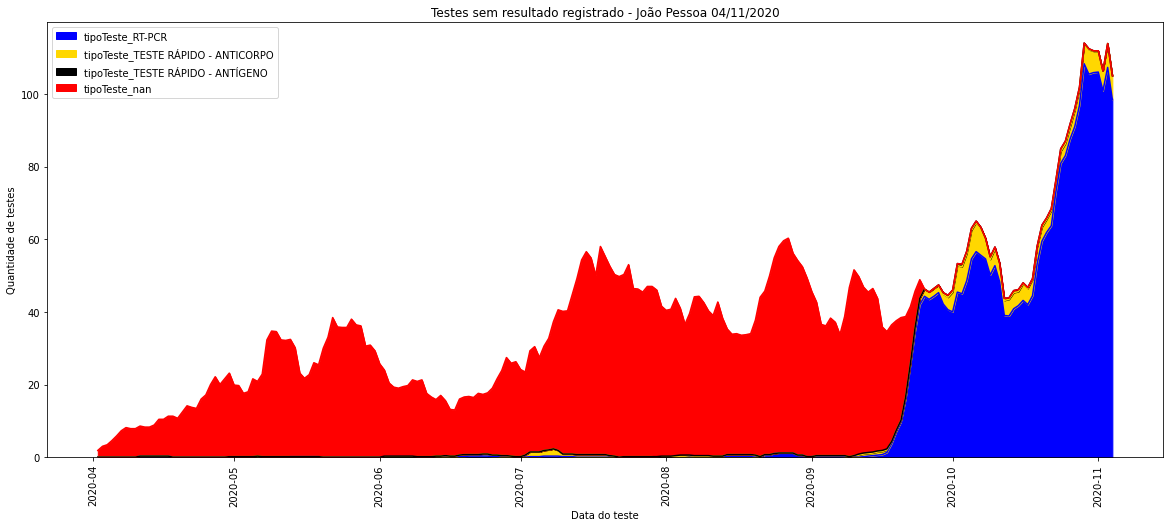

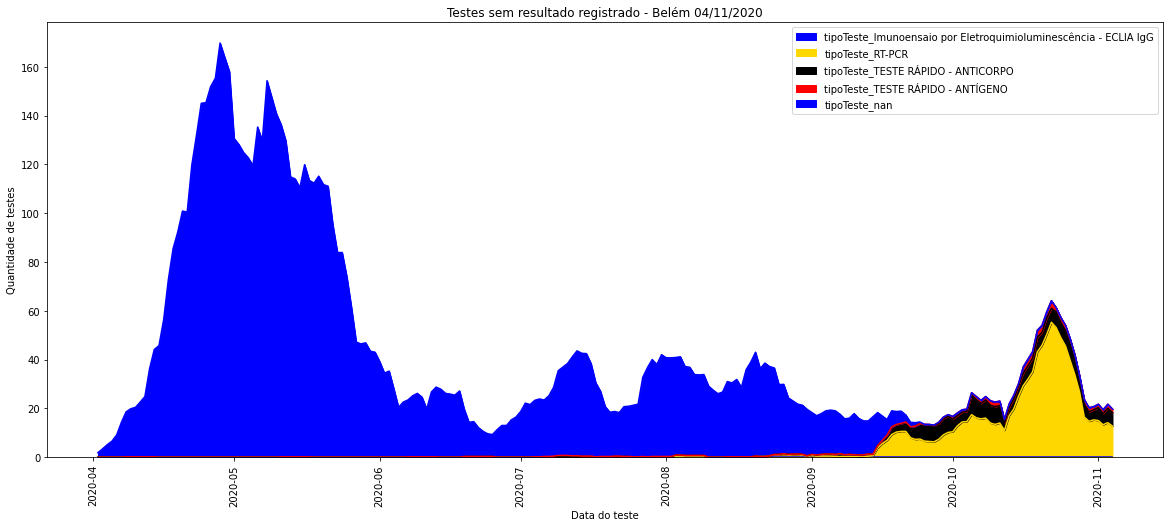

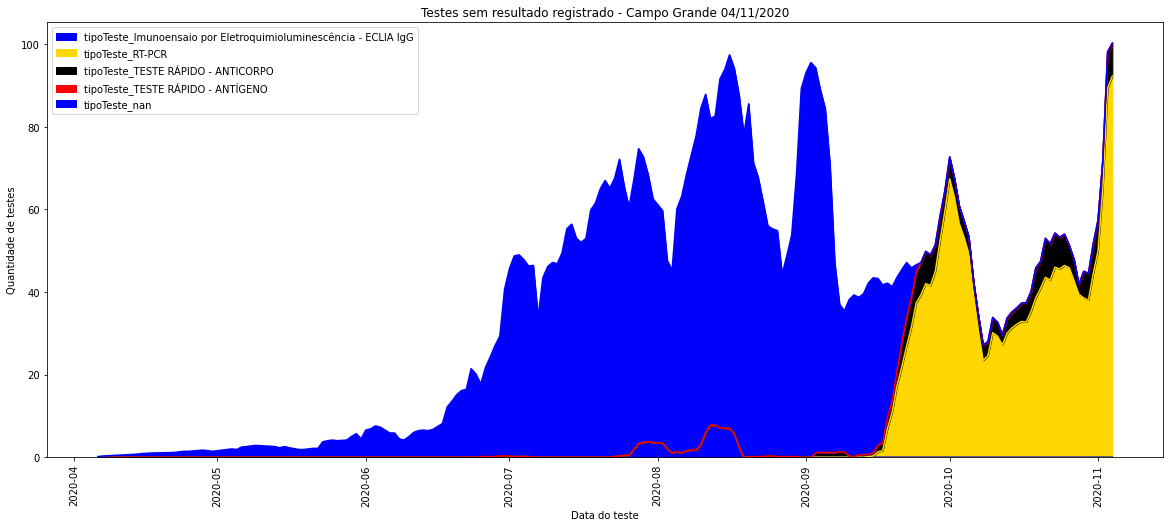

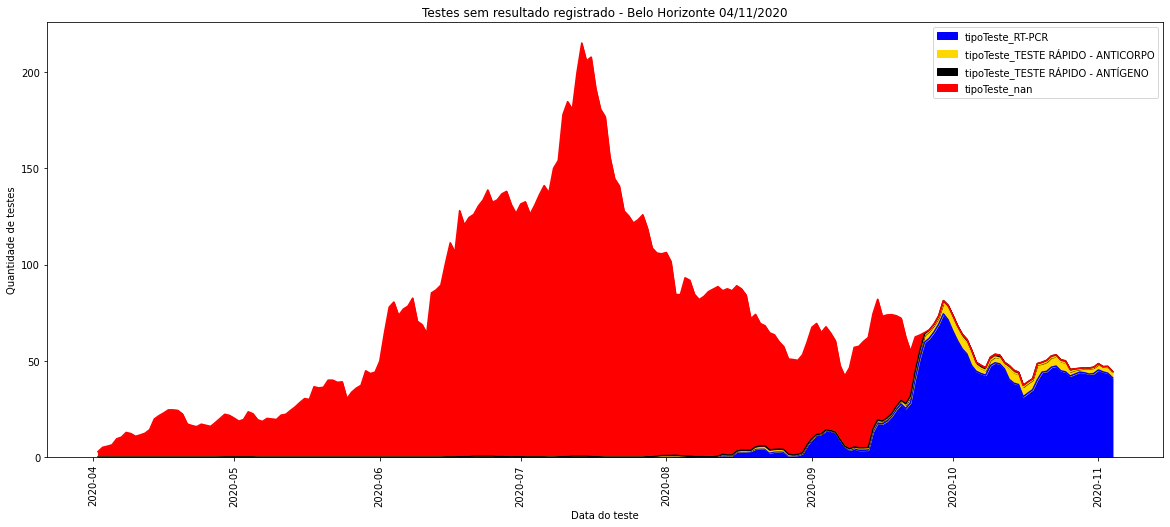

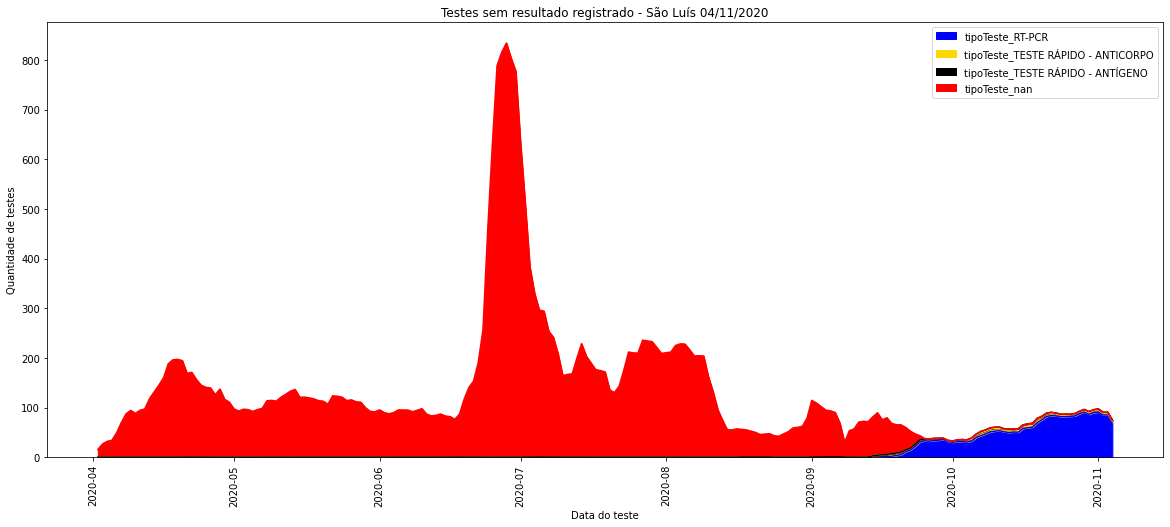

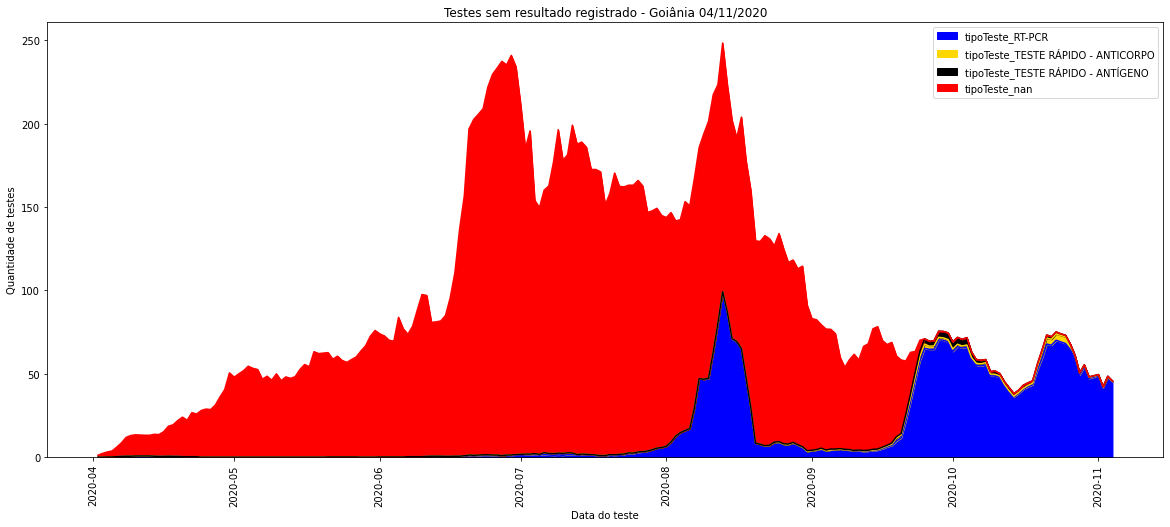

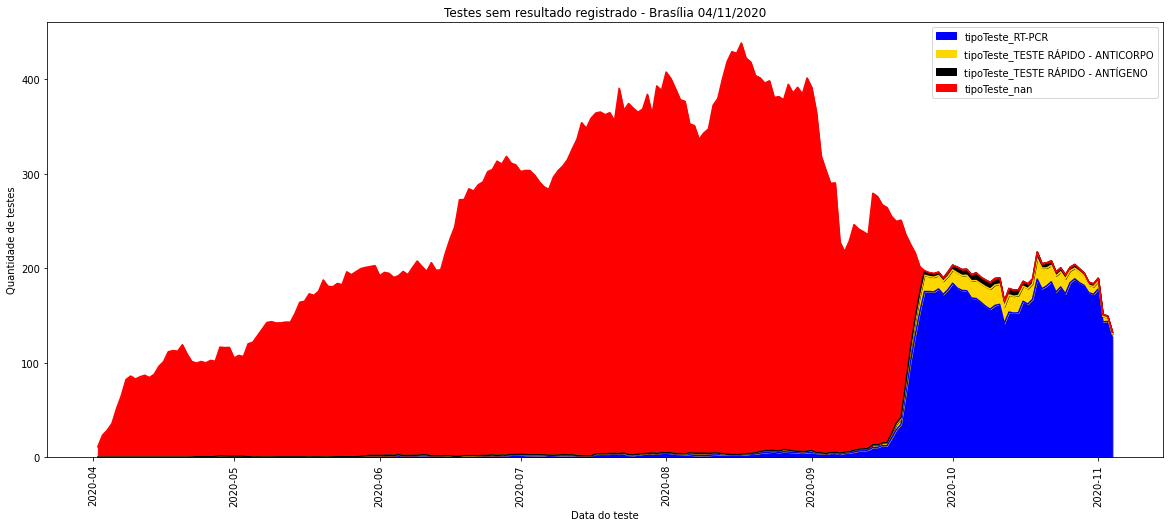

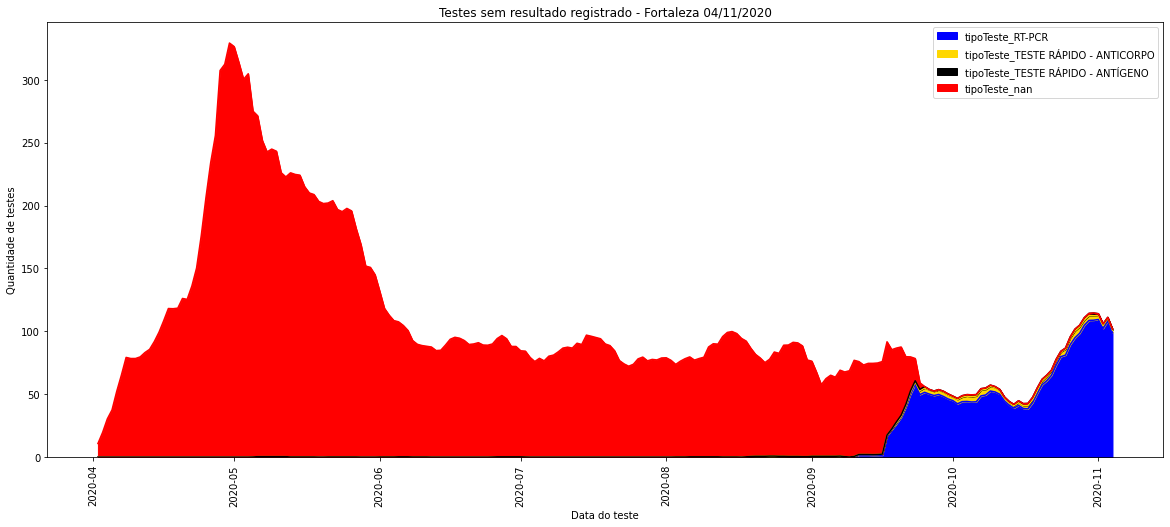

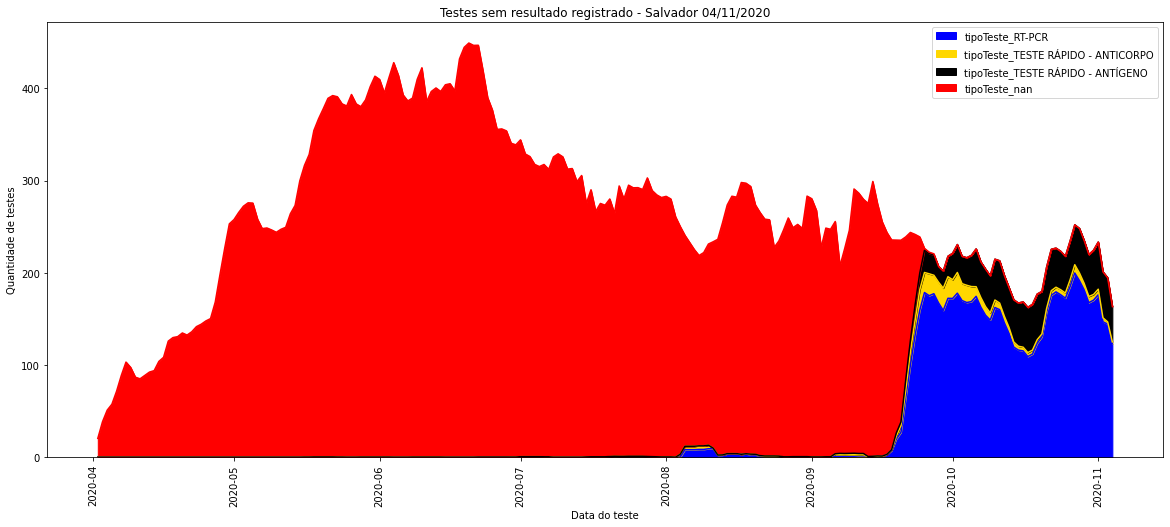

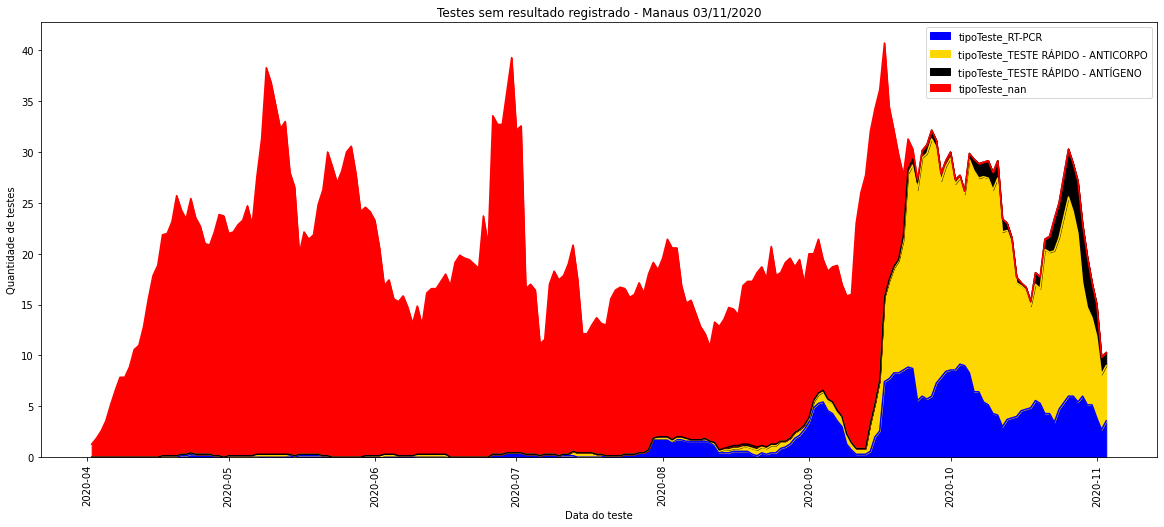

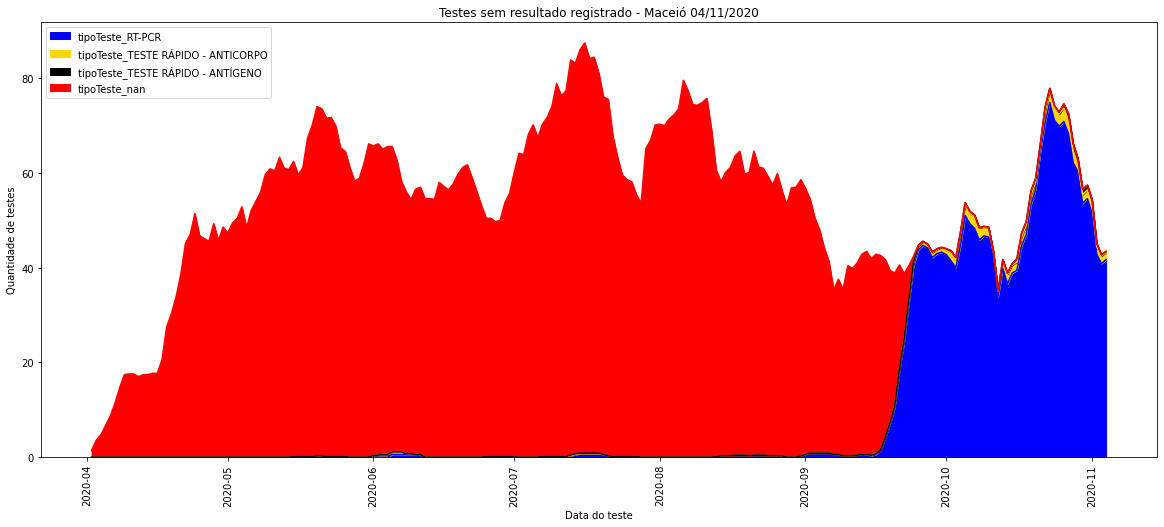

In [11]:
import pandas as pd
import csv
from datetime import datetime
from scipy import stats
import numpy as np

caminho = '/content/drive/My Drive/dados/estados 2020-11-15/'
pop = pd.read_csv('https://raw.githubusercontent.com/romulokps/testesPCR/main/populacaoBR.csv')
pop = pop.sort_values(by = 'pop', ascending=False).head(25)
pop = pop.sort_values(by = 'estado', ascending=False)
pop = pop.reset_index()


for i in pop.index:
    if ((pop.iloc[i]['estado'] != pop.iloc[i-1]['estado']) ):
     df = pd.read_csv(caminho + pop.iloc[i]['estado'], low_memory = False) 
    fe = df  
    #fe = fe[fe['tipoTeste'] == 'RT-PCR']
    fe = fe[fe['municipioNotificacaoIBGE'] == pop.iloc[i]['ibgeID']]
    estado = pop.iloc[i]['cidade']

    fe = fe[fe['resultadoTeste'].isnull()]
    #fe = fe[fe['resultadoTeste'] != 'Inconclusivo ou Indeterminado']
    fe = fe[['dataTeste', 'tipoTeste']]
    fe['dataTeste'] = pd.to_datetime(fe['dataTeste']).dt.date
    fe = fe[fe['dataTeste'] > datetime.strptime('2020-04-01', '%Y-%m-%d').date()]
    fe = fe.replace(np.nan, "nan")
    fe = pd.get_dummies(fe, columns=['tipoTeste'])
    fe = fe.groupby('dataTeste').sum()

    #tira os outliers
    z_scores = stats.zscore(fe)
    abs_z_scores = np.abs(z_scores)
    filtered_entries = (abs_z_scores < 13).all(axis=1)
    fe = fe[filtered_entries]
    
    #faz média móvel para suavizar 
    janela = 7
    for i in range(len(fe.columns)):
      fe[fe.columns[i]] = fe[fe.columns[i]].rolling(min_periods=1, window=janela).sum()/janela

    ax = fe.plot.area(rot=90, figsize = (20,8), color = ["blue","gold","black", "red"])
    ax.set_title("Testes sem resultado registrado - "+estado + fe.index[-1].strftime(' %d/%m/%Y'))
    ax.set_xlabel("Data do teste")
    ax.set_ylabel("Quantidade de testes")
    ax.figure.savefig(caminho + "img/"+ estado + '.png')


In [9]:
pop

,index,Unnamed: 0,ibgeID,cidade,estado,pop,estadoNome
0,3829,3831,3550308,São Paulo,SP,12252023,São Paulo
1,3375,3377,3509502,Campinas,SP,1204073,São Paulo
2,3811,3813,3548708,São Bernardo do Campo,SP,838936,São Paulo
3,3479,3481,3518800,Guarulhos,SP,1379182,São Paulo
4,3824,3826,3549904,São José dos Campos,SP,721944,São Paulo
5,4931,4933,4314902,Porto Alegre,RS,1483771,Rio Grande do Sul
6,1163,1165,2408102,Natal,RN,884122,Rio Grande do Norte
7,3224,3226,3303500,Nova Iguaçu,RJ,821128,Rio de Janeiro
8,3242,3244,3304557,Rio de Janeiro,RJ,6718903,Rio de Janeiro
9,3247,3249,3304904,São Gonçalo,RJ,1084839,Rio de Janeiro
